In [1]:
import torch
import torch.nn.functional as F
from torch import nn

In [2]:
class BiLSTM(nn.Module):
    inference_chunk_length = 512

    def __init__(self, input_features, recurrent_features):
        super().__init__()
        self.rnn = nn.LSTM(input_features, recurrent_features, batch_first=True, bidirectional=True)

    def forward(self, x):
        if self.training:
            return self.rnn(x)[0]
        else:
            # evaluation mode: support for longer sequences that do not fit in memory
            batch_size, sequence_length, input_features = x.shape
            hidden_size = self.rnn.hidden_size
            num_directions = 2 if self.rnn.bidirectional else 1

            h = torch.zeros(num_directions, batch_size, hidden_size, device=x.device)
            c = torch.zeros(num_directions, batch_size, hidden_size, device=x.device)
            output = torch.zeros(batch_size, sequence_length, num_directions * hidden_size, device=x.device)

            # forward direction
            slices = range(0, sequence_length, self.inference_chunk_length)
            for start in slices:
                end = start + self.inference_chunk_length
                output[:, start:end, :], (h, c) = self.rnn(x[:, start:end, :], (h, c))

            # reverse direction
            if self.rnn.bidirectional:
                h.zero_()
                c.zero_()

                for start in reversed(slices):
                    end = start + self.inference_chunk_length
                    result, (h, c) = self.rnn(x[:, start:end, :], (h, c))
                    output[:, start:end, hidden_size:] = result[:, :, hidden_size:]

            return output


In [18]:
class ConvStack(nn.Module):
    def __init__(self, input_features, output_features):
        super().__init__()

        # input is batch_size * 1 channel * frames * input_features
        self.cnn = nn.Sequential(
            # layer 0
            nn.Conv2d(1, output_features // 16, (3, 3), padding=1),
            nn.BatchNorm2d(output_features // 16),
            nn.ReLU(),
            # layer 1
            nn.Conv2d(output_features // 16, output_features // 16, (3, 3), padding=1),
            nn.BatchNorm2d(output_features // 16),
            nn.ReLU(),
            # layer 2
            nn.MaxPool2d((1, 2)),
            nn.Dropout(0.25),
            nn.Conv2d(output_features // 16, output_features // 8, (3, 3), padding=1),
            nn.BatchNorm2d(output_features // 8),
            nn.ReLU(),
            # layer 3
            nn.MaxPool2d((1, 2)),
            nn.Dropout(0.25),
        )
        self.fc = nn.Sequential(
            nn.Linear((output_features // 8) * (input_features // 4), output_features),
            nn.Dropout(0.5)
        )

    def forward(self, mel):
        x = mel.view(mel.size(0), 1, mel.size(1), mel.size(2))
        x = self.cnn(x)
        print(f'CNN output shape = {x.shape}')
        x = x.transpose(1, 2).flatten(-2)
        print(f'flatten output shape = {x.shape}')
        x = self.fc(x)
        print(f'fc output shape = {x.shape}')
        return x

In [19]:
class OnsetsAndFrames(nn.Module):
    def __init__(self, input_features, output_features, model_complexity=48):
        super().__init__()

        model_size = model_complexity * 16 # 786
        sequence_model = lambda input_size, output_size: BiLSTM(input_size, output_size // 2)

#         self.onset_stack = nn.Sequential(
#             ConvStack(input_features, model_size),
#             sequence_model(model_size, model_size),
#             nn.Linear(model_size, output_features),
#             nn.Sigmoid()
#         )

        self.Conv_Stack = ConvStack(input_features, model_size)
        self.BiLSTM = sequence_model(model_size, model_size) #
        self.FC_sigmoid = nn.Sequential(nn.Linear(model_size, output_features),
                                        nn.Sigmoid())
        
        
    def forward(self, mel):
        x = self.Conv_Stack(mel)
        print(f'Conv_Stack output shape = {x.shape}')
        x = self.BiLSTM(x)
        print(f'BiLSTM output shape = {x.shape}')
        onset_pred = self.FC_sigmoid(x)
        
        return onset_pred

    def run_on_batch(self, batch):
        audio_label = batch['audio']
        onset_label = batch['onset']
        offset_label = batch['offset']
        frame_label = batch['frame']
        velocity_label = batch['velocity']

        mel = melspectrogram(audio_label.reshape(-1, audio_label.shape[-1])[:, :-1]).transpose(-1, -2)
        onset_pred, offset_pred, _, frame_pred, velocity_pred = self(mel)

        predictions = {
            'onset': onset_pred.reshape(*onset_label.shape),
            'offset': offset_pred.reshape(*offset_label.shape),
            'frame': frame_pred.reshape(*frame_label.shape),
            'velocity': velocity_pred.reshape(*velocity_label.shape)
        }

        losses = {
            'loss/onset': F.binary_cross_entropy(predictions['onset'], onset_label),
            'loss/offset': F.binary_cross_entropy(predictions['offset'], offset_label),
            'loss/frame': F.binary_cross_entropy(predictions['frame'], frame_label),
            'loss/velocity': self.velocity_loss(predictions['velocity'], velocity_label, onset_label)
        }

        return predictions, losses

    def velocity_loss(self, velocity_pred, velocity_label, onset_label):
        denominator = onset_label.sum()
        if denominator.item() == 0:
            return denominator
        else:
            return (onset_label * (velocity_label - velocity_pred) ** 2).sum() / denominator


In [20]:
x = torch.rand(8,640,229)

In [21]:
model=OnsetsAndFrames(229,87)

In [22]:
output, LSTM_output = model(x)

CNN output shape = torch.Size([8, 96, 640, 57])
flatten output shape = torch.Size([8, 640, 5472])
fc output shape = torch.Size([8, 640, 768])
Conv_Stack output shape = torch.Size([8, 640, 768])
BiLSTM output shape = torch.Size([8, 640, 768])


ValueError: too many values to unpack (expected 2)

In [20]:
LSTM_output.shape

torch.Size([8, 640, 768])

In [22]:
model.FC_sigmoid(LSTM_output).shape

torch.Size([8, 640, 87])

In [19]:
output[0].shape

torch.Size([640, 87])

In [31]:
import matplotlib.pyplot as plt

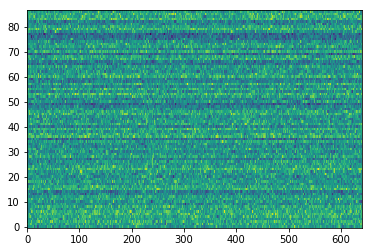

In [19]:
plt.imshow(output[0].detach().cpu().transpose(-2,-1), aspect='auto', origin='lower')